# Gamma from 1D ASCII data

PyMedPhys can also be used to calculate gamma index for one dimensional dose data. Presented here is an example which reads in two .csv files (reference and evaluation dose distributions) as input for the purpose of directly calculating the gamma index of the reference dose distribution. In this example, the refernece dose distribution is from film measurement and the evaluaiton dose distribution is from Monte Carlo simulation. 

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pymedphys
import urllib.request

## Getting the demo .csv files

Let's download the reference and evaluation dose data in .csv files for the purpose of demonstrating gamma analysis for 1D dose data. Users, please note that, there are not explict links of these two .csv files.

## Calculate gamma

In [58]:
reference = np.genfromtxt('dose_film_1D_z0mm.csv',delimiter=',',skip_header=1)
evaluation = np.genfromtxt('dose_MC_1D_z0mm.csv',delimiter=',',skip_header=1)

axis_reference = reference[:, 0] #1st column is x in mm
dose_reference = reference[:, 1] #2nd column is dose in Gy/MU

axis_evaluation = evaluation[:, 0]
dose_evaluation = evaluation[:, 1]
gamma_options = {
    'dose_percent_threshold': 1,
    'distance_mm_threshold': 1,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 10,  # Should be 10 or more for more accurate results
    'max_gamma': 2,
    'random_subset': None,
    'local_gamma': False, # False indicates global gamma is calculated
    'ram_available': 2 ** 29  # 1/2 GB
}
#for global dose normalization, the maximum reference dose is used
#but in TG218, it said usually the prescribed dose or the maximum dose in a plan (evaluation) is used
gamma = pymedphys.gamma(
    axis_reference, dose_reference,
    axis_evaluation, dose_evaluation,
    **gamma_options)

Calcing using global normalisation point for gamma
Global normalisation set to 0.01126
Global dose threshold set to [0.0001126] ([1]% of normalisation)
Distance threshold set to [1]
Lower dose cutoff set to 0.001126 (10% of normalisation)

Current distance: 1.90 mm | Number of reference points remaining: 7 | Points tested per reference point: 2 | RAM split count: 111
Complete!


## Plot the histogram of gamma index

# of reference points with a valid gamma 401


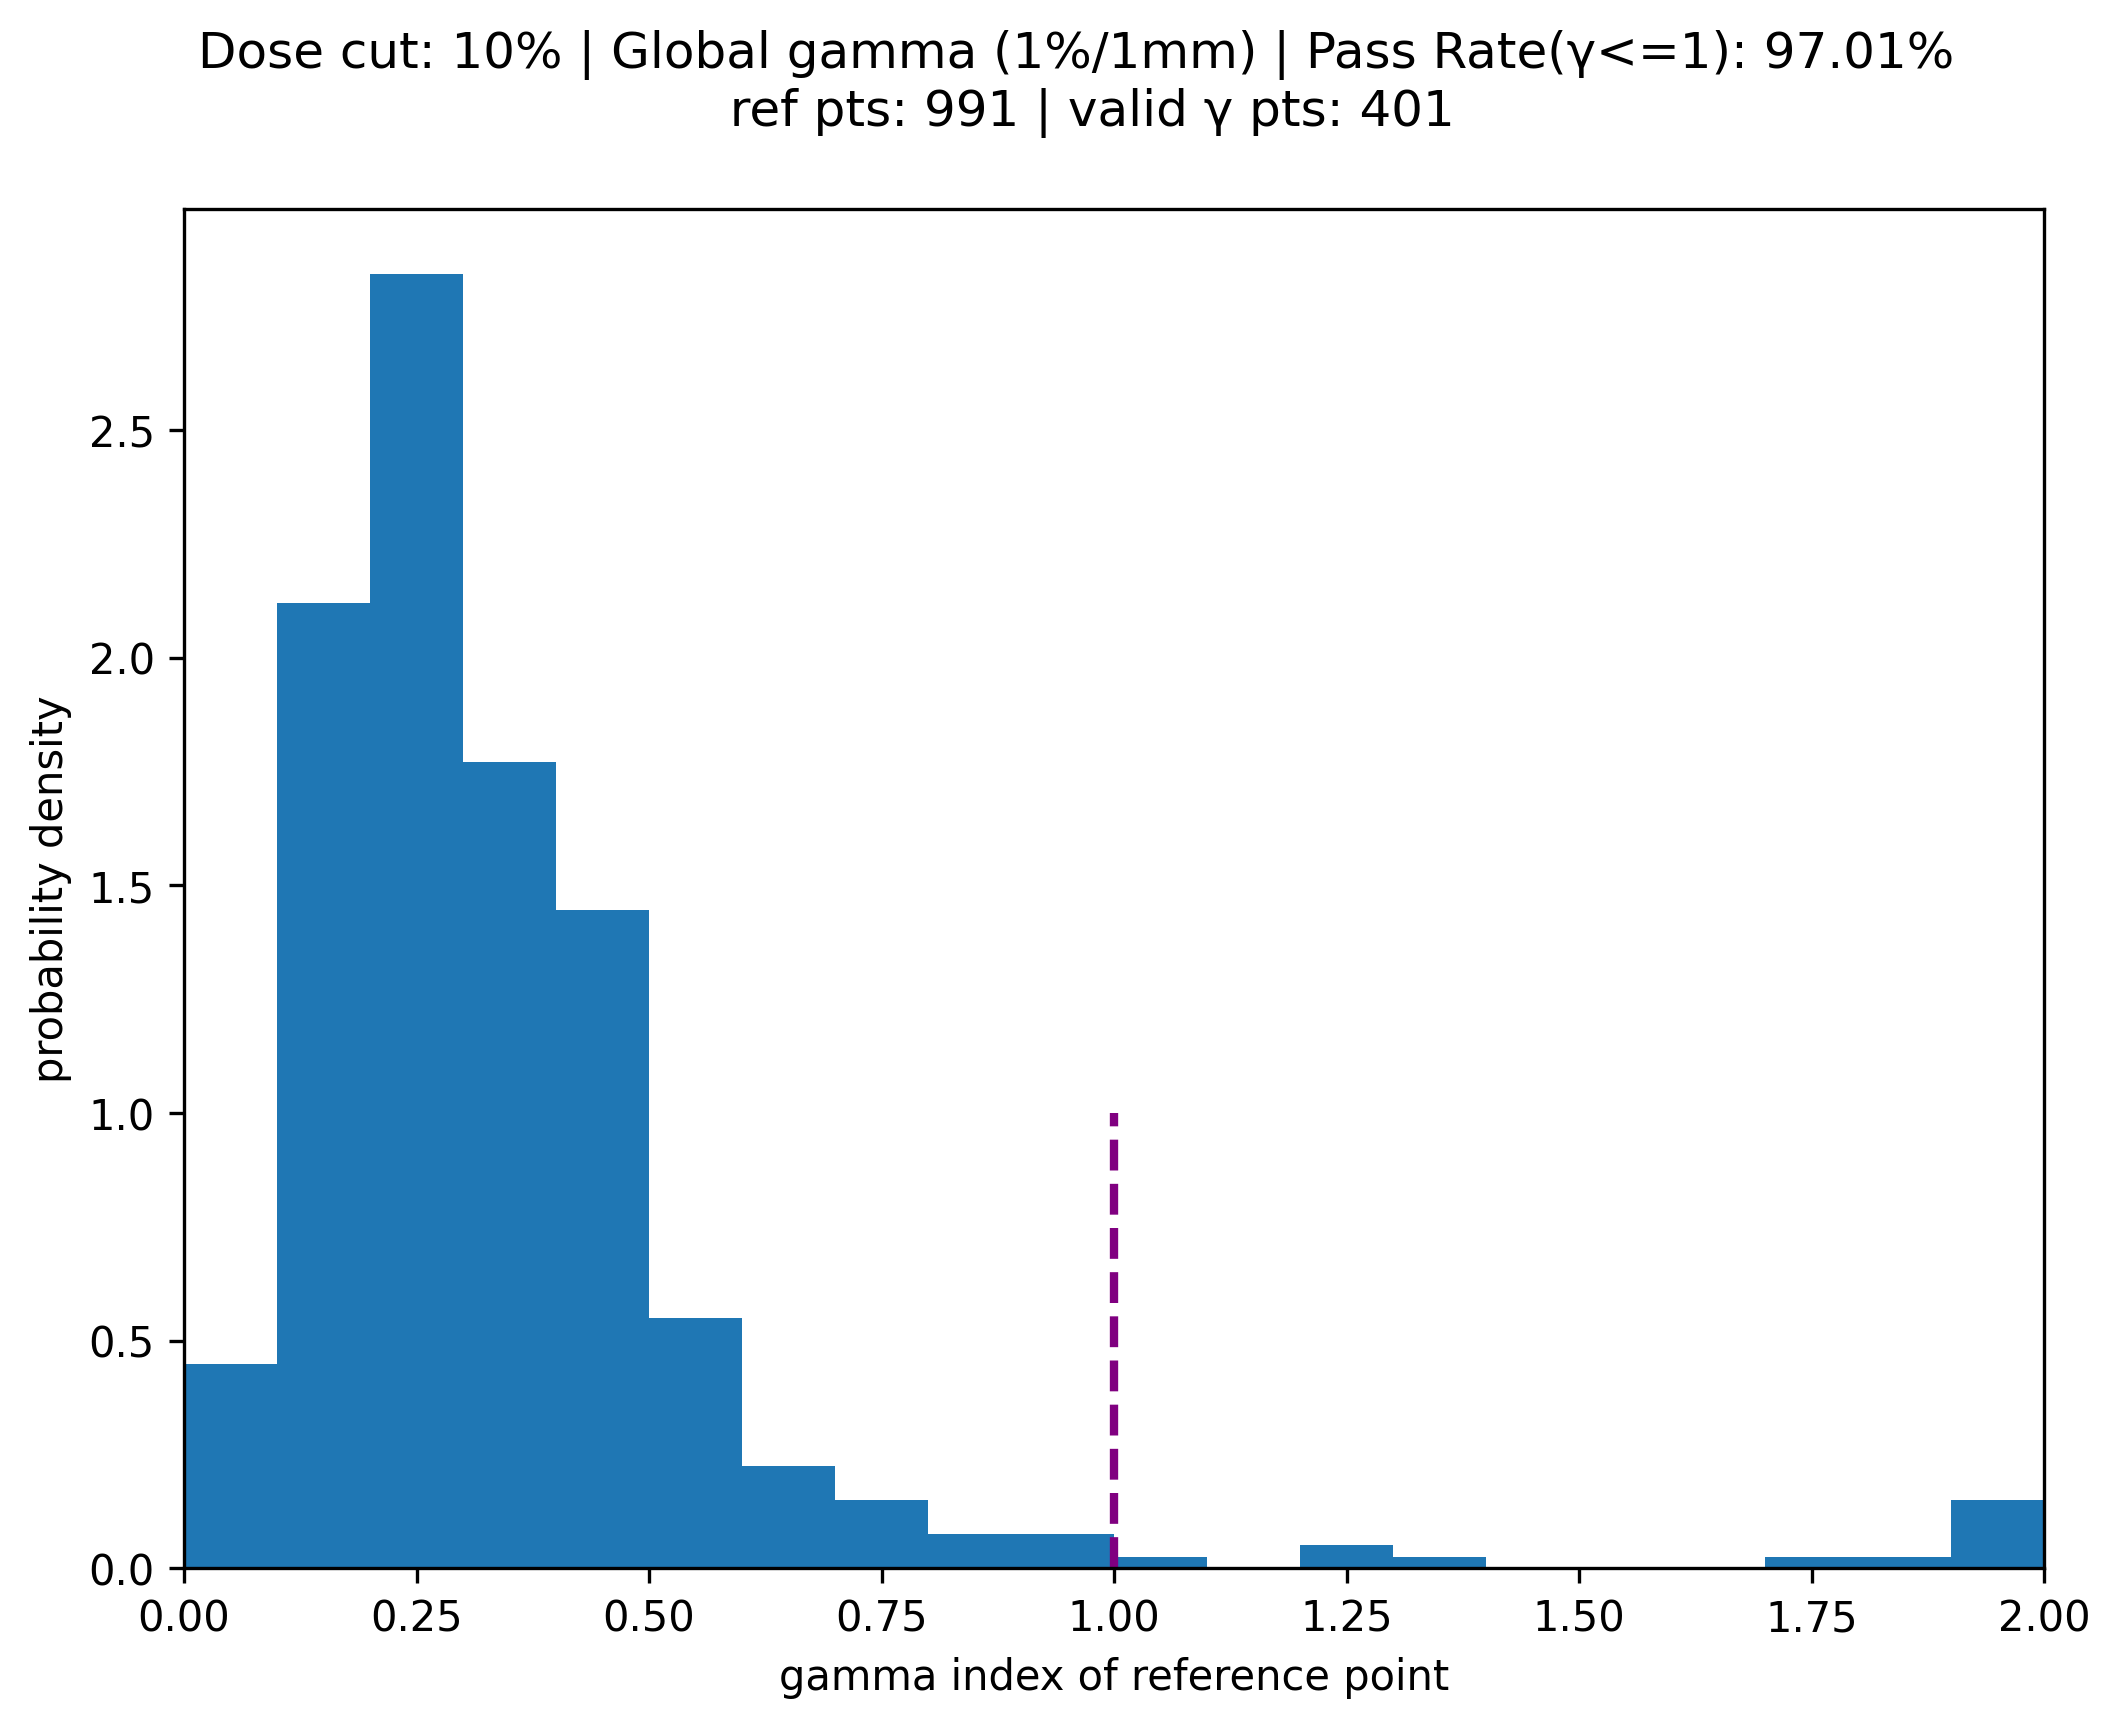

In [59]:
valid_gamma = gamma[~np.isnan(gamma)]
print('# of reference points with a valid gamma {0}'.format( len(valid_gamma)) )
num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

if gamma_options['local_gamma']:
    gamma_norm_condition = 'Local gamma'
else:
    gamma_norm_condition = 'Global gamma'

pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
    
figure_1 = plt.figure(1, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
figure_1.suptitle(f"Dose cut: {gamma_options['lower_percent_dose_cutoff']}% | {gamma_norm_condition} ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Pass Rate(\u03B3<=1): {pass_ratio*100:.2f}% \n ref pts: {len(dose_reference)} | valid \u03B3 pts: {len(valid_gamma)}")

plt.hist(valid_gamma, bins, density=True) #y value is probability density in each bin
#plt.hist(valid_gamma, bins, density=False) #y value is counts in each bin
plt.xlim([0, gamma_options['max_gamma']])
plt.xlabel('gamma index of reference point') #FG
plt.ylabel('probability density')
#plt.ylabel('counts')
plt.vlines(x=[1], ymin=0, ymax=1, colors='purple', ls='--', lw=2, label='target')
plt.savefig('1D_{0}_histogram.png'.format(gamma_norm_condition), dpi=300) #plt.savefig() must be before plt.show()

## Display gamma together with dose points

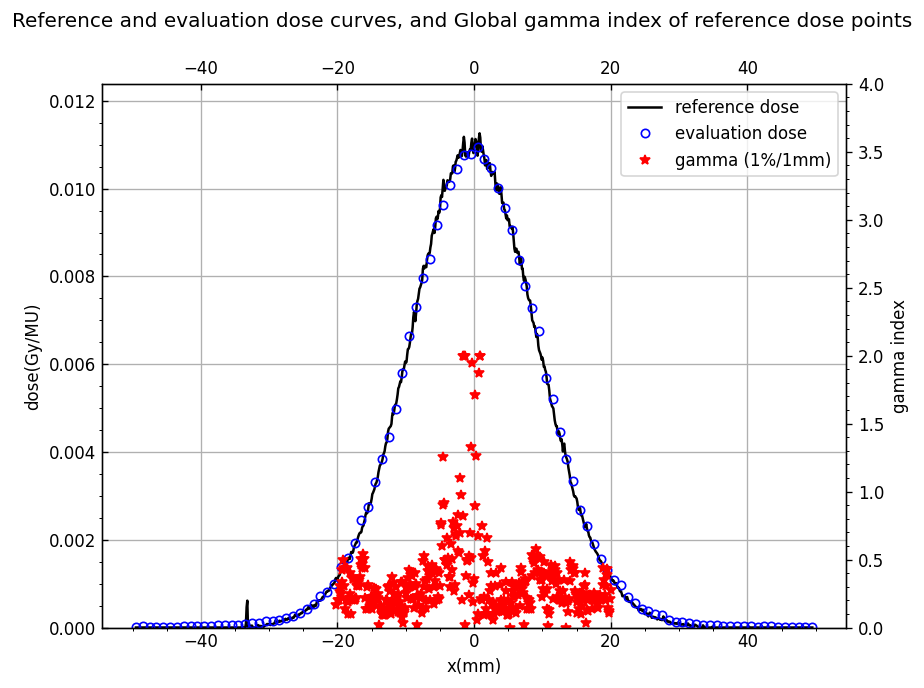

In [60]:
#show gamma index together with dose points
max_ref_dose = np.max(dose_reference) #max reference dose
max_eva_dose = np.max(dose_evaluation) #max evaluation dose
lower_dose_cutoff = gamma_options['lower_percent_dose_cutoff']/100*max_ref_dose

figure_2 = plt.figure(2, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
figure_2.suptitle('Reference and evaluation dose curves, and {0} index of reference dose points'.format(gamma_norm_condition),fontsize=12)

ax_1 = figure_2.add_subplot(111)
ax_1.tick_params(direction='in')
ax_1.tick_params(axis='x', bottom='on', top='on')  
ax_1.tick_params(labeltop='on')
ax_1.minorticks_on()
ax_1.set_xlabel('x(mm)')
ax_1.set_ylabel('dose(Gy/MU)')
ax_1.set_ylim([0, max(max_ref_dose,max_eva_dose) * 1.1])


ax_2 = ax_1.twinx()
ax_2.minorticks_on()
ax_2.set_ylabel('gamma index')
ax_2.set_ylim([0, gamma_options['max_gamma'] * 2.0 ])

curve_0 = ax_1.plot(axis_reference, dose_reference,'k-',label='reference dose')
curve_1 = ax_1.plot(axis_evaluation, dose_evaluation,'bo', mfc='none', markersize=5, label='evaluation dose')
curve_2 = ax_2.plot(axis_reference, gamma, 'r*', label=f"gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm)")
curves = curve_0 + curve_1 + curve_2

labels = [l.get_label() for l in curves] 
ax_1.legend(curves, labels, loc='best') 
ax_1.grid(True)

# save figure first and show it
figureName = '1D dose_reference_evaluation_{0} index.png'.format(gamma_norm_condition)
plt.savefig(figureName) #plt.savefig() must be before plt.show()
plt.show()